<a href="https://colab.research.google.com/github/sean-halpin/ml_tweepy_proj/blob/main/svm_text_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

Mounted at /content/drive/


In [ ]:
!pip install vaderSentiment
!pip install spellchecker
!pip install pyspellchecker
!pip install plot_keras_history

In [3]:
import numpy as np
import pandas as pd 
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
df = pd.read_csv("tweets_annotated.1650577206.elonmusk.csv")

In [5]:
stop_words = set(stopwords.words('english'))
def no_stopwords(text):
  tokenwords = word_tokenize(text) 
  result = [w for w in tokenwords if not w in stop_words] 
  result = [] 
  for w in tokenwords: 
      if w not in stop_words: 
          result.append(w)
  return " ".join(result)

In [6]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [7]:
output= string.punctuation
print('list of punctuations:', output)

list of punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [9]:
df['tweet'] = df['tweet'].str.replace('http\S+|www.\S+|@.\S+|&amp;.\S+|<.*?>', '', case=False)
df['tweet'] = df['tweet'].str.lower()
df['tweet'] = df['tweet'].str.strip()
df['tweet'] = df['tweet'].str.translate(str.maketrans('', '', output))
df['lemmatized_tweet'] = df['tweet'].apply(lemmatize_text).apply(no_stopwords)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [10]:
df = df.drop_duplicates('lemmatized_tweet', keep='last')

In [11]:
X = df.lemmatized_tweet.values.reshape(-1,1)
y = df.sentiment.values.reshape(-1,1)

In [12]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X,y)
print(sorted(Counter(y_resampled).items()))

[('negative', 1239), ('neutral', 1239), ('positive', 1239)]


In [13]:
df_resampled = pd.DataFrame ({ 'lemmatized_tweet': X_resampled.flatten(), 'sentiment': y_resampled})

In [14]:
df_resampled.head()

,lemmatized_tweet,sentiment
0,truist analyst lowered twtr rating hold buy ap...,negative
1,reminder still think elon musk bayseddd whatev...,negative
2,tell elon lying opened mouth typed something t...,negative
3,well happens one able say real elon musk anymo...,negative
4,elon ha secured financing poison pill showing ...,negative


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled.lemmatized_tweet, df_resampled.sentiment, test_size=0.2, random_state=32)

# Text Classifier

In [50]:
text_clf = Pipeline([
    ('vect', CountVectorizer(max_features=100)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=3, tol=None)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.5120967741935484

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
def clf_metrics(y_test, predicted):
  print(metrics.classification_report(y_test, predicted))
  c_matrix = metrics.confusion_matrix(y_test, predicted)
  ax = sns.heatmap(c_matrix, annot=True,      
                    xticklabels=['negative','neutral','positive'],                
                    yticklabels=['negative','neutral','positive'],                
                  cbar=True, cmap='Blues', fmt='g')
  ax.set_xlabel("Prediction")
  ax.set_ylabel("Actual")

              precision    recall  f1-score   support

    negative       0.50      0.56      0.53       236
     neutral       0.52      0.52      0.52       265
    positive       0.52      0.46      0.49       243

    accuracy                           0.51       744
   macro avg       0.51      0.51      0.51       744
weighted avg       0.51      0.51      0.51       744



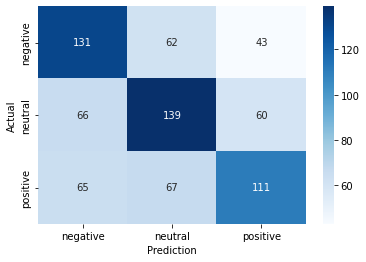

In [52]:
clf_metrics(y_test, predicted)

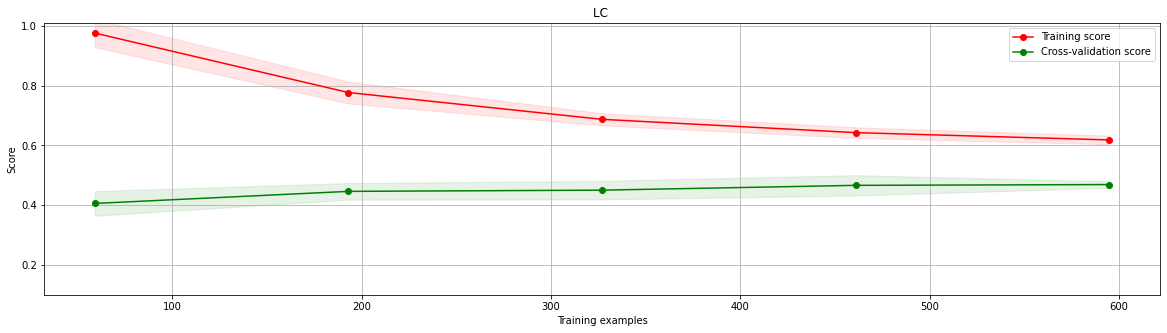

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, (ax) = plt.subplots(1, 1, figsize=(20, 5))

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")
    return plt


plot_learning_curve(
    text_clf, "LC ", X=X_test, y=y_test,ylim=(0.1, 1.01), cv=5, n_jobs=-1
)

plt.show()

# Vader

In [54]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [55]:
analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(sentence):
  vs = analyzer.polarity_scores(sentence)
  comp = vs['compound']
  if comp > 0.05:
    return 'positive'
  elif comp < -0.05:
    return 'negative'
  else:
    return 'neutral'

In [56]:
vader_predicted = X_test.apply(vader_sentiment)

              precision    recall  f1-score   support

    negative       0.68      0.50      0.58       236
     neutral       0.59      0.40      0.48       265
    positive       0.48      0.77      0.59       243

    accuracy                           0.56       744
   macro avg       0.58      0.56      0.55       744
weighted avg       0.58      0.56      0.55       744



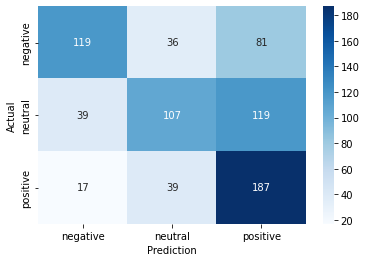

In [57]:
clf_metrics(y_test, vader_predicted)

In [58]:
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [59]:
len(X_test[(y_test == "neutral") & (vader_predicted == "positive")])

119

In [60]:
X_test[(y_test == "neutral") & (vader_predicted == "positive")]

2454    tesla worker say pay price elon musk big promise                                                                                           
1436    strategic would pay far elon musk way happens antitrust enviornment obvious board hold elon without violating fiduciary duty               
1612    elon musk twitteri satyn alsa vpnsiz girer aly ediweri buy twitter make possible enter twitter without vpn twitter banned country gayrat et
2237    wooo thanks motivation mo envy elon musk                                                                                                   
1719    check article marketwatch elon musk say ha received funding commitment twitter buyout exploring tender offer                               
                                                            ...                                                                                    
1470    original poster implied wa elon musk supposed worshipping love car                                      

# Deep Neural Network Classifier

In [61]:
import numpy as np
import pandas as pd
import re
import gensim
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [62]:
def labels_categorical(data):
  labels = np.array(data)
  y = []
  for i in range(len(labels)):
      if labels[i] == 'neutral':
          y.append(0)
      if labels[i] == 'negative':
          y.append(1)
      if labels[i] == 'positive':
          y.append(2)
  y = np.array(y)
  labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
  del y
  return labels

In [63]:
labels = labels_categorical(df_resampled.sentiment)

In [72]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 500
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_resampled.lemmatized_tweet)
sequences = tokenizer.texts_to_sequences(df_resampled.lemmatized_tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[  0   0   0 ... 728 729  16]
 [  0   0   0 ...  90 350 115]
 [  0   0   0 ... 222   2 125]
 ...
 [  0   0   0 ... 118 206 191]
 [  0   0   0 ... 507   2   1]
 [  0   0   0 ... 855 119 133]]


In [73]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.3, random_state=32)

In [74]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2601, 200)
(1116, 200)
(2601, 3)
(1116, 3)


In [109]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding
embedding_layer = Embedding(100, 32)

model1 = Sequential()
model1.add(layers.Embedding(max_words, 5))
model1.add(layers.LSTM(4,dropout=0.4, return_sequences=False))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [110]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 5)           5000      
                                                                 
 lstm_11 (LSTM)              (None, 4)                 160       
                                                                 
 dense_7 (Dense)             (None, 3)                 15        
                                                                 
Total params: 5,175
Trainable params: 5,175
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint1])

In [112]:
import keras

best_model = keras.models.load_model("best_model1.hdf5")

In [113]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

35/35 - 1s - loss: 0.8480 - accuracy: 0.6263 - 758ms/epoch - 22ms/step
Model accuracy:  0.6263440847396851


In [114]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.54      0.71      0.61       387
           1       0.68      0.61      0.64       357
           2       0.67      0.52      0.59       372

    accuracy                           0.61      1116
   macro avg       0.63      0.61      0.61      1116
weighted avg       0.63      0.61      0.61      1116



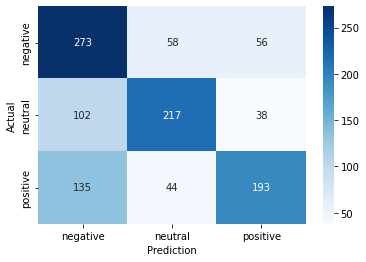

In [115]:
clf_metrics(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

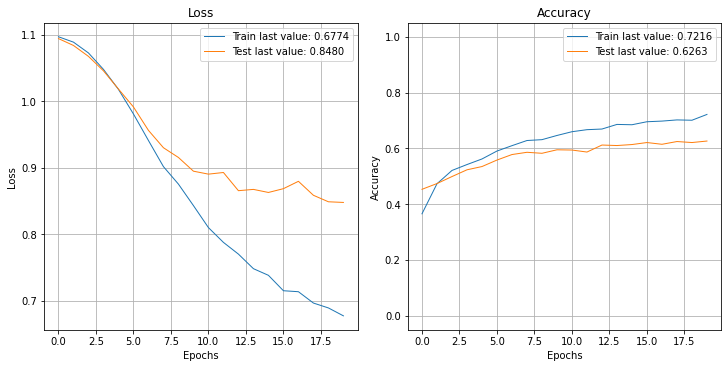

In [116]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)
plot_history(history, path="standard.png")
plt.close()